## Text Classification

In [1]:
from datasets import list_datasets
all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the hub.")
print(f"The first 10 are {all_datasets[:10]}")



/Users/jcarlson/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/var/folders/d5/hdy_gn3j6y708g2rsdglvv_m0000gn/T/ipykernel_95204/3893147912.py:2: FutureWarning: list_datasets is deprecated and will be removed in the next major version of datasets. Use 'huggingface_hub.list_datasets' instead.
  all_datasets = list_datasets()


There are 133536 datasets currently available on the hub.
The first 10 are ['acronym_identification', 'ade_corpus_v2', 'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news', 'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [2]:
from datasets import load_dataset
emotions = load_dataset("emotion")

/Users/jcarlson/Library/Python/3.9/lib/python/site-packages/datasets/load.py:1461: FutureWarning: The repository for emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [4]:
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [5]:
len(train_ds)

16000

In [6]:
print(train_ds[0])
train_ds.column_names

{'text': 'i didnt feel humiliated', 'label': 0}


['text', 'label']

In [7]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy'], 'label': [0, 0, 3, 2, 3]}


In [8]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake', 'im grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the fireplace i will know that it is still on the property', 'i am feeling grouchy']


#### Convert to DataFrames

Data structure also contains labeled axes (rows and columns). Arithmetic operations align on both row and column labels. Can be thought of as a dict-like container for Series objects. The primary pandas data structure.

```d = {'col1': [1, 2], 'col2': [3, 4]}
df = pd.DataFrame(data=d)
df
   col1  col2
0     1     3
1     2     4
```

In [9]:
import pandas as pd
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


Let's expand the label into a name - the integers aren't very helpful

In [10]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


Time to look at the distribution ...

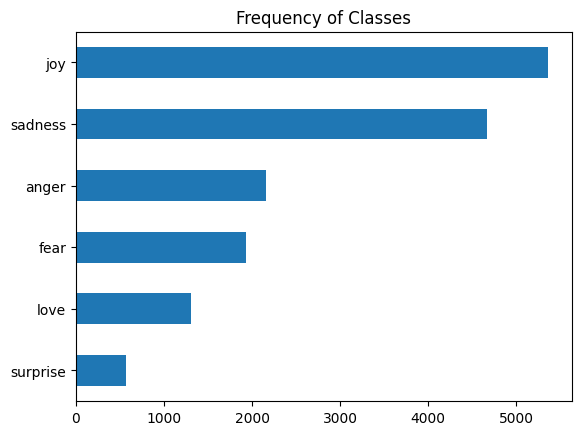

In [11]:
import matplotlib.pyplot as plt
df["label_name"].value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

Transformers have a maximum input sequence length that is called a maximum content size. For applications using DistilBERT, the max content size is 512 ttokens. 

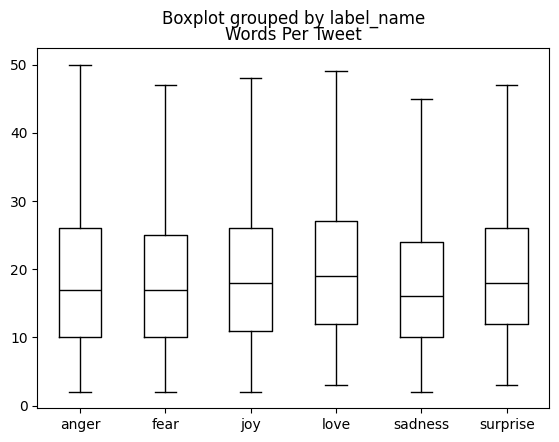

In [12]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet",by="label_name",grid=False, showfliers=False, color="black")

plt.xlabel("")
plt.show()

### Tokenization

Time to take the strings (tweets) and tokenize them.

In [13]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [14]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [15]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


If we wanted to encode for the characters.

In [16]:

categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [17]:

pd.get_dummies(categorical_df["Name"])
     

,Bumblebee,Megatron,Optimus Prime
0,1,0,0
1,0,0,1
2,0,1,0


The rows of this DataFrame are the one-hot vectors, which have a single "hot" entry with a 1 and 0s everywhere else. Now, looking at our input_ids, we have a similar problem: the elements create an ordinal scale. This means that adding or subtracting two IDs is a meaningless operation, since the result is a new ID that represents another random token.

### One-hot Vectors

One hot encoding is a technique that we use to represent categorical variables as numerical values in a machine learning model.

The advantages of using one hot encoding include:

* It allows the use of categorical variables in models that require numerical input.
* It can improve model performance by providing more information to the model about the categorical variable.
* It can help to avoid the problem of ordinality, which can occur when a categorical variable has a natural ordering (e.g. “small”, “medium”, “large”).

The disadvantages of using one hot encoding include:
* It can lead to increased dimensionality, as a separate column is created for each category in the variable. This can make the model more complex and slow to train.
* It can lead to sparse data, as most observations will have a value of 0 in most of the one-hot encoded columns.
* It can lead to overfitting, especially if there are many categories in the variable and the sample size is relatively small.

One-hot-encoding is a powerful technique to treat categorical data, but it can lead to increased dimensionality, sparsity, and overfitting. It is important to use it cautiously and consider other methods such as ordinal encoding or binary encoding.

In [18]:
import torch
import torch.nn.functional as F

input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [19]:
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Word Tokenization

Instead of splitting text into characters, words often makes more sense, and then those words are mapped to integers.

In [20]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


However, one of the problems here is tokenization of the puncutation, which is very meaningful semantically. So, a compromise is **Subword Tokenization**, where the idea is to combine the best ideas of character tokenization and word tokenization. On the one hand, we want to split rare words into smaller units to allow the model to deal with complex words and misspellings. On the other hand, we want to keep frequent words as unique entities so that we can keep the length of our inputs to a manageaable size. 

There are several subword tokenization algorithms commonly used in NLP, but here, we'll start with **WordPiece**, which is used by BERT and DistilBERT.

In [21]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)


The **AutoTokenizer** belongs to a larger set of "auto" classes, whose job is to automatically retrieve the model's configuration, pretrained weights, or vocabulary from the name of the checkpoint. This allows you to quickly switch between models, but if you wish to load the specific class manually you can do so as well.


In [22]:
from transformers import DistilBertTokenizer 
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [23]:
print(text)
encoded_text = tokenizer(text)
print(encoded_text)

Tokenizing text is a core task of NLP.
{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [24]:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


First, some special [CLS] and [SEP] tokens have been added to the start and end of the sequence. These tokens differ from model to model, but their main role is to indicate the start and end of a sequence. 

In [25]:
print(tokenizer.convert_tokens_to_string(tokens))
print(f"The vocabularly size {tokenizer.vocab_size}")
print(f"The model max length is {tokenizer.model_max_length}")
tokenizer.model_input_names

[CLS] tokenizing text is a core task of nlp. [SEP]
The vocabularly size 30522
The model max length is 512


['input_ids', 'attention_mask']

## Tokenizing the whole dataset

In [26]:
# first a procesing function 
def tokenize(batch):
    return tokenizer(str(batch["text"]), padding=True, truncation=True)

In [27]:
print(str(emotions["train"]["text"][:2]))
tokenize(emotions["train"][:2])


0                              i didnt feel humiliated
1    i can go from feeling so hopeless to so damned...
Name: text, dtype: object


{'input_ids': [101, 1014, 1045, 2134, 2102, 2514, 26608, 1015, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 1012, 1012, 1012, 2171, 1024, 3793, 1010, 26718, 18863, 1024, 4874, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [28]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

This applies the processing function across all the splits of a corpus, in just a single line.

In [29]:
print(emotions_encoded["train"].column_names)

['input_ids', 'attention_mask']


## Training a Text Classifier

We ahve two options:
1. Use the hidden states of transformer and train a classifier on those hidden states; these does not need any modification of the pretrained model. 
2. Fine-tuning; where we train the whole model end-to-end.

Let's try both!

In [30]:
from transformers import AutoModel

model_ckpt = "distilbert-base-uncased"
print(f"Are we using Cude? {torch.cuda.is_available()}")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

Are we using Cude? False


In [31]:
# if we can use the Apple GPU
print(f"Apple GPU is available? {torch.backends.mps.is_available()}")

Apple GPU is available? True


In [32]:
# Extract the hidden state for a single string
text = "this is a test" 
inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")
print(inputs)


Input tensor shape: torch.Size([1, 6])
{'input_ids': tensor([[ 101, 2023, 2003, 1037, 3231,  102]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1]])}


Now that we have the tesnor, to get the hidden state place the encodings on the same device as the model and pass the inputs (essentially, map it!)

In [33]:
inputs = {k:v.to(device) for k,v in inputs.items()}
print(f"inputs are {type(inputs)}")
with torch.no_grad():
    outputs = model(**inputs)
print(outputs)

inputs are <class 'dict'>
BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ..., -0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]), hidden_states=None, attentions=None)


In [34]:
outputs.last_hidden_state.size()


torch.Size([1, 6, 768])

To do the same for the entire batch, we define a function:

In [35]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

We need to convert the input_ids and attention_mask columns to torch format

In [37]:
emotions_encoded.set_format("torch", columns=["input_ids","attention_mask"])
# now we can extrac the hidden states across all splits in one go.
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

Map:   0%|          | 0/151 [00:00<?, ? examples/s]

RuntimeError: The size of tensor a (151) must match the size of tensor b (512) at non-singleton dimension 1

## Fine Tuning the Transformer

In [38]:
from transformers import AutoModelForSequenceClassification

num_labels = 0
model = (AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels).to(device))


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
type(model)

transformers.models.distilbert.modeling_distilbert.DistilBertForSequenceClassification

In [40]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids 
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average='weighted')
    acc = accuracy_score(labels, preds)
    return {"accuracy":acc, "f1":f1}

Login into Hugging Face

In [42]:
from huggingface_hub import notebook_login
notebook_login()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [44]:
from transformers import Trainer, TrainingArguments

batch_size = 64
logging_steps = len(emotions_encoded["train"])
model_name = f"{model_ckpt}-finetuned-emotion"
training_args = TrainingArguments(output_dir=model_name,
                                  num_train_epochs=2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  logging_steps=logging_steps,
                                  push_to_hub=False,
                                  log_level="error")

trainer = Trainer(model=model, args=training_args,
                  compute_metrics=compute_metrics,
                  train_dataset=emotions_encoded["train"],
                  eval_dataset=emotions_encoded["validation"],
                  tokenizer=tokenizer)
trainer.train()

/Users/jcarlson/Library/Python/3.9/lib/python/site-packages/accelerate/accelerator.py:436: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/t